In [392]:
#import pwb_toolbox.datasets as pwb_ds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
import torch
from datetime import datetime, timedelta
import torch
import torch.nn as nn
from torch.nn import functional as F
import pickle
import re
from six import BytesIO
import matplotlib.dates as mdates
import scipy.stats as stats
import seaborn as sns
import pymysql.cursors
from accelerate import Accelerator
import spacy
import ftfy
from torch.utils.data import DataLoader, TensorDataset
import ast
import math
import itertools
from torch.utils.data import DataLoader
from tqdm import tqdm

In [144]:
def get_previous_date(date_str, days_before):
    date_obj = datetime.strptime(date_str, '%Y/%m/%d')
    before_date = date_obj - timedelta(days=days_before)
    before_date_str = before_date.strftime('%Y/%#m/%#d')
    return before_date_str

def get_above_date(date_str, days_after):
    date_obj = datetime.strptime(date_str, '%Y/%m/%d')
    after_date = date_obj + timedelta(days=days_after)
    after_date_str = after_date.strftime('%Y/%#m/%#d')
    return after_date_str

get_above_date('2015/12/30', 3)
get_previous_date('2015/12/10', 3)

'2015/12/7'

# Load data from the Hugging Face

Daily data for stock

In [46]:
#get data from each parquet file

#file1
df = pd.read_parquet("train-00000-of-00004.parquet")
df.to_csv("stockdata1.csv", index=False)
us_1 = df['symbol'].unique()

#file2
df2 = pd.read_parquet("train-00001-of-00004.parquet")
df2.to_csv("stockdata2.csv", index=False)
us_2 = df2['symbol'].unique()

#file3
df3 = pd.read_parquet("train-00002-of-00004.parquet")
df3.to_csv("stockdata3.csv", index=False)
us_3 = df3['symbol'].unique()

#file4
df4 = pd.read_parquet("train-00003-of-00004.parquet")
df4.to_csv("stockdata4.csv", index=False)
us_4 = df4['symbol'].unique()

array(['A', 'AA', 'AACBU', ..., 'CYTK', 'CZFS', 'CZNC'], dtype=object)

Get the list of stock name

In [102]:
#merge 4 parquet
array1 = np.array(us_1)
array2 = np.array(us_2)
array3 = np.array(us_3)
array4 = np.array(us_4)

stock_list = np.concatenate([array1, array2, array3, array4])
stock_list

array(['A', 'AA', 'AACBU', ..., 'ZYME', 'ZYXI', 'ZZZ'], dtype=object)

Balance sheet for stocks (to calculate turnover rate)

In [124]:
df5 = pd.read_parquet("stock_sheet.parquet")
df5.to_csv("balance_sheet.csv", index=False)

Delete the data before 2010 & Only leave symbol, date, close and volume

In [123]:
# for daily price files
df["date"] = pd.to_datetime(df["date"])
df1_new = df[(df["date"] >= "2010-01-01") & (df['date']<= "2024-12-31")][["symbol", "date", "volume", "adj_close"]]

df2["date"] = pd.to_datetime(df2["date"])
df2_new = df2[(df2["date"] >= "2010-01-01") & (df2['date']<= "2024-12-31")][["symbol", "date", "volume", "adj_close"]]

df3["date"] = pd.to_datetime(df3["date"])
df3_new = df3[(df3["date"] >= "2010-01-01") & (df3['date']<= "2024-12-31")][["symbol", "date", "volume", "adj_close"]]

df4["date"] = pd.to_datetime(df4["date"])
df4_new = df4[(df4["date"] >= "2010-01-01") & (df4['date']<= "2024-12-31")][["symbol", "date", "volume", "adj_close"]]

#merge all the data
df_stockdata = pd.concat([df1_new, df2_new, df3_new, df4_new], ignore_index=True)
df_stockdata.to_csv('stocklist.csv', index=False)

In [38]:
df_stockdata = pd.read_csv('stocklist.csv')
df_stockdata

,symbol,date,volume,adj_close
0,A,2010-01-04,3815561,20.016037
1,A,2010-01-05,4186031,19.798605
2,A,2010-01-06,3243779,19.728260
3,A,2010-01-07,3095172,19.702677
4,A,2010-01-08,3733918,19.696283
...,...,...,...,...
13851617,ZYXI,2024-12-24,0,0.430476
13851618,ZYXI,2024-12-26,2750,0.425584
13851619,ZYXI,2024-12-27,0,0.425584
13851620,ZYXI,2024-12-30,4730,0.430476


In [386]:
# for balance sheet data
df5["date"] = pd.to_datetime(df5["date"])
dfshares = df5[(df5["date"] >= "2010-01-01") & (df5['date']<= "2024-12-31")][["symbol", "date", "common_stock_shares_outstanding"]]

#save to csv
dfshares.to_csv("bs2.csv", index=False)

NameError: name 'df5' is not defined

Leave the stocks which are both included in two dataset

In [8]:
common_symbols = set(dfshares["symbol"]).intersection(set(df_stockdata["symbol"]))
dfshares = dfshares[dfshares["symbol"].isin(common_symbols)]
df_stockdata = df_stockdata[df_stockdata["symbol"].isin(common_symbols)]

#check whether the length of the financial data and the trading data are the same
len(dfshares['symbol'].unique()) == len(df_stockdata['symbol'].unique())

True

Delete the stocks do not have data before 2023/4 (according to the setting of the experiment)

In [9]:
df_stockdata["date"] = pd.to_datetime(df_stockdata["date"])

# the setting time
cutoff_date = pd.Timestamp("2023-04-01")

# the earlist trading day for each stock
first_trade_dates = df_stockdata.groupby("symbol")["date"].min()

#only save stocks had traded before 2023/04
valid_symbols = first_trade_dates[first_trade_dates < cutoff_date].index

# save stocks in all sets
df_stockdata = df_stockdata[df_stockdata["symbol"].isin(valid_symbols)]
dfshares = dfshares[dfshares["symbol"].isin(valid_symbols)]
len(dfshares['symbol'].unique()) == len(df_stockdata['symbol'].unique())

<ipython-input-9-7619a47bf279>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stockdata["date"] = pd.to_datetime(df_stockdata["date"])


True

Get timeline (align with balance sheet one)

In [177]:
df_timeline = df_stockdata['date'].unique()
df_timeline

<DatetimeArray>
['2010-01-04 00:00:00', '2010-01-05 00:00:00', '2010-01-06 00:00:00',
 '2010-01-07 00:00:00', '2010-01-08 00:00:00', '2010-01-11 00:00:00',
 '2010-01-12 00:00:00', '2010-01-13 00:00:00', '2010-01-14 00:00:00',
 '2010-01-15 00:00:00',
 ...
 '2024-12-17 00:00:00', '2024-12-18 00:00:00', '2024-12-19 00:00:00',
 '2024-12-20 00:00:00', '2024-12-23 00:00:00', '2024-12-24 00:00:00',
 '2024-12-26 00:00:00', '2024-12-27 00:00:00', '2024-12-30 00:00:00',
 '2024-12-31 00:00:00']
Length: 3774, dtype: datetime64[ns]

Get the list of the stocks whehter have transaction exception

In [183]:
#all trading dates
all_trading_dates = set(df_timeline)

# not satify stocks
stocks_with_missing_dates = []

for symbol, group in df_stockdata.groupby("symbol"):
    stock_dates = set(group["date"])
    
    #the first trade date of the stock
    first_trading_day = min(stock_dates)
    last_trading_day = max(stock_dates)
    
    # the whole tading dates that the stock should have
    required_dates = {d for d in all_trading_dates if first_trading_day <= d <= last_trading_day}
    
    # check whether miss any
    if stock_dates != required_dates:
        stocks_with_missing_dates.append(symbol)

#the abnormal stock
print("These stocks cannot cover all the trading days：")
print(stocks_with_missing_dates)

以下股票未能涵盖所有交易日：
['CRVO', 'DAY', 'DBRG', 'DDD', 'DECK', 'DEO', 'DGICA', 'DHCNI', 'DHI', 'DMRC', 'DNA', 'DOOO', 'DOYU', 'DPZ', 'DRH', 'DRIO', 'DRRX', 'DRUG', 'DSGR', 'DSS', 'DT', 'DTB', 'E', 'EBAY', 'EFSH', 'EHAB', 'ELMD', 'ELV', 'ELWS', 'EMN', 'ENSC', 'EQ', 'EQX', 'ERNA', 'ESOA', 'ESRT', 'EVER', 'EVOK', 'EVRI', 'EXPI', 'EYE', 'EZGO', 'FCRX', 'FFIV', 'FFNW', 'FIHL', 'FLDD', 'FLNT', 'FMBH', 'FMS', 'FORM', 'FRSX', 'FSTR', 'FSV', 'FTK', 'FTLF', 'FTV', 'FUSB', 'FWRD', 'GAMB', 'GCTS', 'GDHG', 'GDOT', 'GECCO', 'GEF', 'GEF-B', 'GFL', 'GLAD', 'GMAB', 'GMGT', 'GOGL', 'GOOD', 'GOSS', 'GPJA', 'GPRO', 'GRCE', 'GRFS', 'GROV', 'GROW', 'GRVY', 'GRYP', 'GS', 'GTX', 'GUG', 'GWAV', 'GWRE', 'HBCP', 'HEI-A', 'HESM', 'HLIO', 'HLLY', 'HLXB', 'HMST', 'HOFT', 'HONE', 'HQY', 'HTOO', 'HURN', 'HWC', 'HYAC', 'ICL', 'IGMS', 'IKNA', 'INFY', 'INO', 'INTEU', 'INTU', 'INVH', 'INVX', 'IPDN', 'ISRLU', 'ISSC', 'ITOS', 'ITP', 'JBGS', 'JBLU', 'JD', 'JILL', 'JKS', 'JYD', 'KBR', 'KFRC', 'KFS', 'KIM', 'KLTR', 'KPRX', 'KRNT', 'KR

In [198]:
df_stockdata = df_stockdata[~df_stockdata["symbol"].isin(stocks_with_missing_dates)]
dfshares = dfshares[~dfshares["symbol"].isin(stocks_with_missing_dates)]
len(dfshares['symbol'].unique()) == len(df_stockdata['symbol'].unique())

True

Merge data for each month

In [39]:
df_stockdata['date'] = pd.to_datetime(df_stockdata['date'])

# add year-month
df_stockdata['year_month'] = df_stockdata['date'].dt.to_period('M')

def summarize_month(group):
    volume_sum = group['volume'].sum()
    first_price = group.iloc[0]['adj_close']
    last_price = group.iloc[-1]['adj_close']
    adj_close_change = (last_price - first_price) / first_price if first_price != 0 else None
    return pd.Series({'volume': volume_sum, 'adj_close_change': adj_close_change})

df_stockdata_monthly = df_stockdata.sort_values('date').groupby(['symbol', 'year_month']).apply(summarize_month).reset_index()

df_stockdata_monthly

,symbol,year_month,volume,adj_close_change
0,A,2010-01,79961545.0,-0.104474
1,A,2010-02,108263356.0,0.079987
2,A,2010-03,120154045.0,0.071673
3,A,2010-04,106280992.0,0.049493
4,A,2010-05,124702438.0,-0.119935
...,...,...,...,...
520354,ZYXI,2024-08,378510.0,0.200001
520355,ZYXI,2024-09,267740.0,-0.100000
520356,ZYXI,2024-10,158510.0,-0.211111
520357,ZYXI,2024-11,103400.0,0.025000


In [40]:
#save to the csv
df_stockdata_monthly.to_csv('stocklist_monthly.csv', index=False)

Merge df_stockdata_monthly and dfshares

In [60]:
# merge directly, not consider NaN
dfshares['date'] = pd.to_datetime(dfshares['date'])
dfshares['year_month'] = dfshares['date'].dt.to_period('M').astype(str)
df_stockdata_monthly['year_month'] = df_stockdata_monthly['year_month'].astype(str)

# create a dict
shares_lookup = {
    (row.symbol, row.year_month): row.common_stock_shares_outstanding
    for row in dfshares.itertuples(index=False)
}

# add by apply
df_stockdata_monthly['common_stock_shares_outstanding'] = df_stockdata_monthly.apply(
    lambda row: shares_lookup.get((row.symbol, row.year_month), None),
    axis=1
)

#fill the table
# fill to head
df_stockdata_monthly['common_stock_shares_outstanding'] = (
    df_stockdata_monthly.groupby('symbol')['common_stock_shares_outstanding']
    .ffill()
)

# fill to tail
df_stockdata_monthly['common_stock_shares_outstanding'] = (
    df_stockdata_monthly.groupby('symbol')['common_stock_shares_outstanding']
    .bfill()
)

df_stockdata_monthly

In [128]:
#get the final df_stockdata_monthly
df_stockdata_monthly['turnover_rate'] = (
    df_stockdata_monthly['volume'] / df_stockdata_monthly['common_stock_shares_outstanding']
)

df_stockdata_monthly['turnover_rate'] = df_stockdata_monthly['turnover_rate'].round(4)

# delete rows where turnover_rate is NaN
df_stockdata_monthly = df_stockdata_monthly.dropna(subset=['turnover_rate'])

#delete NaN of the shares
df_stockdata_monthly = df_stockdata_monthly.dropna(subset=['common_stock_shares_outstanding'])

df_stockdata_monthly['year'] = df_stockdata_monthly['year_month'].str[:4].astype(int)

# count how many data before 2020 (for training)
symbol_pre2020_counts = (
    df_stockdata_monthly[df_stockdata_monthly['year'] < 2020]
    .groupby('symbol')
    .size()
)

#find the symbol that includes less 20 data 
symbols_to_filter_out = symbol_pre2020_counts[symbol_pre2020_counts < 20].index.tolist()

# delete the data
df_stockdata_monthly = df_stockdata_monthly[
    ~((df_stockdata_monthly['symbol'].isin(symbols_to_filter_out)) & (df_stockdata_monthly['year'] < 2020))
].reset_index(drop=True)

# delete the "year" colume
df_stockdata_monthly.drop(columns=['year'], inplace=True)

df_stockdata_monthly

#save to the csv
df_stockdata_monthly.to_csv("stocklist_monthly.csv", index=False)

,symbol,year_month,volume,adj_close_change,common_stock_shares_outstanding,turnover_rate
0,A,2010-01,79961545.0,-0.104474,348000000.0,0.2298
1,A,2010-02,108263356.0,0.079987,348000000.0,0.3111
2,A,2010-03,120154045.0,0.071673,348000000.0,0.3453
3,A,2010-04,106280992.0,0.049493,348000000.0,0.3054
4,A,2010-05,124702438.0,-0.119935,348000000.0,0.3583
...,...,...,...,...,...,...
457088,ZYXI,2024-08,378510.0,0.200001,31725742.0,0.0119
457089,ZYXI,2024-09,267740.0,-0.100000,31840092.0,0.0084
457090,ZYXI,2024-10,158510.0,-0.211111,31840092.0,0.0050
457091,ZYXI,2024-11,103400.0,0.025000,31840092.0,0.0032


# Building the training set

In [195]:
df_pivot_ready = df_stockdata_monthly[['symbol', 'year_month', 'adj_close_change', 'turnover_rate']].copy()

# align with the df
df_pivot_ready = df_pivot_ready.rename(columns={
    'adj_close_change': 'profit',
    'turnover_rate': 'turnover' 
})

# multi-index，and transform unstack to wide format
df_wide = df_pivot_ready.set_index(['symbol', 'year_month']).unstack('year_month')

df_wide.columns = [ (ym, metric) for metric, ym in df_wide.columns ]

# rank index
df_wide = df_wide.sort_index(axis=1, level=0)

df_input_monthly = df_wide

#save to the file
df_input_monthly.to_csv("stock_input.csv")

df_input_monthly

,"(2010-01, profit)","(2010-01, turnover)","(2010-02, profit)","(2010-02, turnover)","(2010-03, profit)","(2010-03, turnover)","(2010-04, profit)","(2010-04, turnover)","(2010-05, profit)","(2010-05, turnover)",...,"(2024-08, profit)","(2024-08, turnover)","(2024-09, profit)","(2024-09, turnover)","(2024-10, profit)","(2024-10, turnover)","(2024-11, profit)","(2024-11, turnover)","(2024-12, profit)","(2024-12, turnover)"
symbol,,,,,,,,,,,,,,,,,,,,,
A,-0.104474,0.2298,0.079987,0.3111,0.071673,0.3453,0.049493,0.3054,-0.119935,0.3583,...,0.000420,0.1168,0.068509,0.1085,-0.110876,0.1075,0.008037,0.1564,-0.035762,0.1140
AA,-0.235435,2.3169,-0.002302,1.5741,0.069872,1.8103,-0.086395,1.8120,-0.112713,1.9328,...,0.023368,0.8227,0.276638,0.5197,0.025703,0.4628,0.144442,0.4054,-0.173304,0.3652
AACG,-0.361702,0.0110,0.117647,0.0147,0.046753,0.0819,-0.115288,0.0088,-0.076704,0.0090,...,-0.092308,0.0197,0.327586,0.0317,0.177215,0.0464,-0.009901,0.0310,-0.132653,0.0130
AAL,0.113207,0.7882,0.308929,0.6928,-0.044213,0.5220,-0.044595,0.9812,0.194858,0.7868,...,0.047337,0.9905,0.060377,1.2473,0.229358,1.2092,0.072378,0.7048,0.193019,0.8257
AAME,0.053030,0.0045,0.000000,0.0059,0.096296,0.0041,0.162338,0.0045,-0.203297,0.0038,...,0.052632,0.0041,0.036585,0.0059,-0.053571,0.0047,-0.067485,0.0059,0.013158,0.0039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUMZ,-0.101158,0.0947,0.041930,0.0705,0.194516,0.2394,0.077547,0.1138,0.246320,0.2054,...,-0.013437,0.8432,0.012802,0.5839,0.178604,0.7859,-0.010417,0.7643,-0.096838,0.6372
ZVRA,0.119101,0.0296,0.258400,0.0463,0.102362,0.0481,-0.103158,0.0247,0.031702,0.0560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZVSA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
#let "symbol" in the df be one of the columns in the df (it was the index at the beginning)
df_input_monthy = df_input_monthly.reset_index()

In [221]:
def find_symbols_with_nan(df, late_date, n):
    #obtain the first 2n colume
    columns_to_check = df.columns[df.columns.get_loc(late_date) - 2 * n : df.columns.get_loc(late_date)]

    # find the column including NaN and return the symbol of the colume
    symbols_with_nan = df[df[columns_to_check].isna().any(axis=1)].index

    return set(symbols_with_nan)

In [222]:
def create_df_profit_rate_with_symbol(df_input, date_str, date):  # date is the index of the date
    
    #find the symbol including NaN in the past 40 col
    symbols_with_nan = find_symbols_with_nan(df_input, date_str, 40)
    
    # save the symbol excluded in the NaN set
    df_profit_rate = df_input.loc[~df_input.index.isin(symbols_with_nan)]

    #the past 40 col + present col (41 col in addition)
    selected_columns = list(df_profit_rate.columns[date - 40 : date + 1])

    df_profit_rate = df_profit_rate[selected_columns]
    df_profit_rate = df_profit_rate.reset_index()

    #sort and remove NaN
    df_profit_rate = df_profit_rate.sort_values(by=[(date_str, 'profit')], ascending=False).dropna().reset_index(drop=True)

    return df_profit_rate


In [226]:
def create_df_profit_rate(df_input, date_str, date):  # date is the index of the date
    
    #find the symbol including NaN in the past 40 col
    symbols_with_nan = find_symbols_with_nan(df_input, date_str, 40)
    
    # save symbol without NaN
    df_profit_rate = df_input.loc[~df_input.index.isin(symbols_with_nan)]
    
    # choose the 40 col + present 1 col
    df_profit_rate = df_profit_rate[df_profit_rate.columns[date - 40:date + 1]]

    # sort by (date_str, 'profit')
    df_profit_rate = df_profit_rate.sort_values(by=[date_str], ascending=False)

    # remove prossible NaN
    df_profit_rate = df_profit_rate.dropna().reset_index(drop=True)

    return df_profit_rate


In [224]:
def normalize_dataframe(df):
    #calculate the mean and std for each column
    mean_values = df.iloc[:, 0:-1].mean()
    std_values = df.iloc[:, 0:-1].std()

    # normalize except the last colume (for traget label)
    for col in df.columns[0:-1]:
        df[col] = (df[col] - mean_values[col]) / std_values[col]

    return df

In [233]:
#the first date of the dataset is the 40th col
date = 40
output_list = []
input_list = []
#the end of the training dataset is 12/2019, which is the 239th col:
while date < 239:

    #get the next date
    date_str = df_input_monthy.columns[date]

    # check whether there are NaN. If included, skip this
    symbols_with_nan = find_symbols_with_nan(df_input_monthy, date_str, 20)
   
    df_profit_rate = create_df_profit_rate(df_input_monthy, date_str, date)

    #targte label
    #date_str_profit_col = f'{date_str}_profit'
        # categrory the stocks based on the t+1 profit with the setting quantile (20%)
    quantiles = pd.qcut(df_profit_rate[date_str], q=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=False)
    df_profit_rate['quantiles'] = quantiles
    
        # the quantile to the traget label: [1, 0, 0], [0, 1, 0], [0, 0, 0], [0, 0, 1]
    encoding = {0: [0, 0, 1], 1: [0, 0, 0], 2: [0, 1, 0], 3: [0, 0, 0], 4: [1, 0, 0]}
    df_profit_rate['encoding'] = df_profit_rate['quantiles'].map(encoding)
    
        #save these to the list
    output_list_temp = df_profit_rate['encoding'].tolist()
    output_list = output_list + output_list_temp
    
    
        #z-score normarlize
    df_profit_nor = normalize_dataframe(df_profit_rate)
    
        # get the first 40th col before the target date that everydate contains a vector, combine them
    profit_turnoff_cols = [col for col in df_profit_nor.columns if 'profit' in col or 'turnoff' in col]
    normalized_df = df_profit_nor.iloc[:, :40]
        
    vector_list_per_row = normalized_df.apply(lambda row: [list(row[i:i+2]) for i in range(0, len(row), 2)], axis=1)
        
        #save to the input_daily.txt
    input_list_temp = vector_list_per_row.tolist()
    input_list = input_list + input_list_temp
    
    date = date + 2
    print(date_str)
                  
#save this to the output.txt
file_path = 'train_output_monthy.txt'

with open(file_path, 'w') as file:
    for item in output_list:
            file.write(str(item) + '\n')        
        
#save to input.txt    
# 指定要写入的文本文件路径
file_path = 'train_input_monthy.txt'

with open(file_path, 'w') as file:
    for item in input_list:
            file.write(str(item) + '\n')
            

('2011-09', 'profit')
('2011-10', 'profit')
('2011-11', 'profit')
('2011-12', 'profit')
('2012-01', 'profit')
('2012-02', 'profit')
('2012-03', 'profit')
('2012-04', 'profit')
('2012-05', 'profit')
('2012-06', 'profit')
('2012-07', 'profit')
('2012-08', 'profit')
('2012-09', 'profit')
('2012-10', 'profit')
('2012-11', 'profit')
('2012-12', 'profit')
('2013-01', 'profit')
('2013-02', 'profit')
('2013-03', 'profit')
('2013-04', 'profit')
('2013-05', 'profit')
('2013-06', 'profit')
('2013-07', 'profit')
('2013-08', 'profit')
('2013-09', 'profit')
('2013-10', 'profit')
('2013-11', 'profit')
('2013-12', 'profit')
('2014-01', 'profit')
('2014-02', 'profit')
('2014-03', 'profit')
('2014-04', 'profit')
('2014-05', 'profit')
('2014-06', 'profit')
('2014-07', 'profit')
('2014-08', 'profit')
('2014-09', 'profit')
('2014-10', 'profit')
('2014-11', 'profit')
('2014-12', 'profit')
('2015-01', 'profit')
('2015-02', 'profit')
('2015-03', 'profit')
('2015-04', 'profit')
('2015-05', 'profit')
('2015-06'

# Training

Quantformer

In [387]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = d_model // num_heads

        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)
        self.W_O = nn.Linear(d_model, d_model)
 
    def forward(self, Q, K, V):
        Q = self.W_Q(Q)
        K = self.W_K(K)
        V = self.W_V(V)

        Q = self._split_heads(Q)
        K = self._split_heads(K)
        V = self._split_heads(V)

        attention_weights = torch.matmul(Q, K.transpose(-1, -2)) / torch.sqrt(torch.tensor(self.depth, dtype=torch.float32))
        attention_weights = torch.softmax(attention_weights, dim=-1)

        output = torch.matmul(attention_weights, V)
        output = self._combine_heads(output)

        output = self.W_O(output)
        return output
 
    def _split_heads(self, tensor):
        tensor = tensor.view(tensor.size(0), -1, self.num_heads, self.depth)
        return tensor.transpose(1, 2)
 
    def _combine_heads(self, tensor):
        tensor = tensor.transpose(1, 2).contiguous()
        return tensor.view(tensor.size(0), -1, self.num_heads * self.depth)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
 
    def forward(self, x):
        attention_output = self.attention(x, x, x)
        attention_output = self.norm1(x + attention_output)

        feedforward_output = self.feedforward(attention_output)
        output = self.norm2(attention_output + feedforward_output)
        return output


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.encoder_attention = MultiHeadAttention(d_model, num_heads)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
 
    def forward(self, x, encoder_output):
        self_attention_output = self.self_attention(x, x, x)
        self_attention_output = self.norm1(x + self_attention_output)

        encoder_attention_output = self.encoder_attention(self_attention_output, encoder_output, encoder_output)
        encoder_attention_output = self.norm2(self_attention_output + encoder_attention_output)

        feedforward_output = self.feedforward(encoder_attention_output)
        output = self.norm3(encoder_attention_output + feedforward_output)
        return output

class Quantformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim):
        super(Quantformer, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.encoder_layers = nn.ModuleList([EncoderLayer(hidden_dim, num_heads) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(hidden_dim, num_heads) for _ in range(num_layers)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
 
    def forward(self, x):
        # Input layer
        x = self.input_layer(x)

        # Encoder layers
        encoder_output = x.transpose(0, 1)
        for layer in self.encoder_layers:
            encoder_output = layer(encoder_output)

        # Decoder layers
        decoder_output = encoder_output
        for layer in self.decoder_layers:
            decoder_output = layer(decoder_output, encoder_output)

        # Select the output of the last time step
        decoder_output = decoder_output[-1, :, :]

        # Output layer
        output = self.output_layer(decoder_output)
        return output


model = Quantformer(input_dim=2, hidden_dim=64, num_heads=8, num_layers=6, output_dim = 3)

In [229]:
def read_data(input_file, output_file, num_samples):
    with open(input_file, 'r') as f_input, open(output_file, 'r') as f_output:
        for _ in range(num_samples):
            input_line = f_input.readline().strip()
            output_line = f_output.readline().strip()

            # Check if either line is empty
            if not input_line or not output_line:
                continue  # Skip empty lines

            try:
                input_data = np.array(ast.literal_eval(input_line), dtype=np.float32)
                output_data = np.array(ast.literal_eval(output_line), dtype=np.float32)
            except SyntaxError:
                continue  # Skip lines causing syntax errors

            yield input_data, output_data

In [240]:
def count_samples(file_path):
    with open(file_path, 'r') as f:
        return sum(1 for _ in f)
num_samples = count_samples('train_output_monthy_cleaned.txt')
num_samples

166210

In [383]:
num_samples = 166210
data_generator = read_data('train_input_monthy_cleaned.txt', 'train_output_monthy_cleaned.txt', num_samples)

inputs_monthy_3 = []
outputs_monthy_3 = []
for _ in range(num_samples):
    input_data, output_data = next(data_generator, (None, None))
    if input_data is not None and output_data is not None:
        inputs_monthy_3.append(input_data)
        outputs_monthy_3.append(output_data)

inputs_monthy_3 = torch.tensor(inputs_monthy_3, dtype=torch.float32)
outputs_monthy_3 = torch.tensor(outputs_monthy_3, dtype=torch.float32)

print(inputs_monthy_3.shape)
print(outputs_monthy_3.shape)

torch.Size([166210, 20, 2])
torch.Size([166210, 3])


In [384]:
# Create a TensorDataset from the inputs and outputs
dataset = TensorDataset(inputs_monthy_3, outputs_monthy_3)

# Define the batch size
batch_size = 512

# Create a DataLoader from the dataset
# Note: we set "shuffle=True" to shuffle the dataset before each epoch of training
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Print the number of batches
print(f'Number of batches: {len(data_loader)}')

Number of batches: 325


In [385]:
model = Quantformer(input_dim=2, hidden_dim=64, num_heads=8, num_layers=6, output_dim = 3)

# Define the loss function (Mean Squared Error Loss)
criterion = nn.MSELoss()

# Initialize the optimizer (Adam optimizer)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 50

# Move the model and the loss function to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

# Start training
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        # Get the inputs and outputs and move them to the GPU if available
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute the outputs by passing inputs to the model
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass: compute the gradients by performing backpropagation
        loss.backward()

        # Update the parameters of the model
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss / len(data_loader)))


torch.save(model, 'trans_model_monthy_1.pth')
torch.save(model.state_dict(), 'trans_params_monthy_1.pth')

Epoch [1/50], Loss: 0.1657
Epoch [2/50], Loss: 0.1602
Epoch [3/50], Loss: 0.1601
Epoch [4/50], Loss: 0.1600
Epoch [5/50], Loss: 0.1601
Epoch [6/50], Loss: 0.1599
Epoch [7/50], Loss: 0.1598
Epoch [8/50], Loss: 0.1598
Epoch [9/50], Loss: 0.1597
Epoch [10/50], Loss: 0.1596
Epoch [11/50], Loss: 0.1596
Epoch [12/50], Loss: 0.1595
Epoch [13/50], Loss: 0.1594
Epoch [14/50], Loss: 0.1595
Epoch [15/50], Loss: 0.1594
Epoch [16/50], Loss: 0.1595
Epoch [17/50], Loss: 0.1593
Epoch [18/50], Loss: 0.1593
Epoch [19/50], Loss: 0.1593
Epoch [20/50], Loss: 0.1594
Epoch [21/50], Loss: 0.1593
Epoch [22/50], Loss: 0.1593
Epoch [23/50], Loss: 0.1594
Epoch [24/50], Loss: 0.1593
Epoch [25/50], Loss: 0.1593
Epoch [26/50], Loss: 0.1593
Epoch [27/50], Loss: 0.1592
Epoch [28/50], Loss: 0.1593
Epoch [29/50], Loss: 0.1592
Epoch [30/50], Loss: 0.1592


KeyboardInterrupt: 

# Backtest base on the result

In [271]:
def predict_list_at_date(df_input, model_params_path, date, rank, o_dim, frequency):
    # determine the date of the column
    if frequency == 'monthy':
        date_str = df_input.columns[date]  # eg. ("2020/01", "profit")
    else:
        column_n = df_input.columns[date]
        date_str = column_n.split('_')[0]

    # obtain the return df
    df_profit_rate = create_df_profit_rate_with_symbol(df_input, date_str, date, frequency)

    # Z-score
    df_profit_nor = normalize_dataframe(df_profit_rate)

    # get profit / turnover col, get the lastest 40 cols
    profit_turnoff_cols = [col for col in df_profit_nor.columns if 'profit' in col or 'turnoff' in col]
    profit_turnoff_cols = sorted(profit_turnoff_cols)[-40:]  

    normalized_df = df_profit_nor[profit_turnoff_cols]

    # build the [x,y] vector
    vector_list_per_row = normalized_df.apply(
        lambda row: [list(row[i:i+2]) for i in range(0, len(row), 2)],
        axis=1
    )

    data = []
    for symbol, vector in zip(df_profit_rate.index, vector_list_per_row):
        data.append([symbol, vector, None])

    df_date_rank = pd.DataFrame(data, columns=['symbol', 'vector', 'rank'])
    df_date_rank.set_index('symbol', inplace=True) 

    # get the prediction
    df_date_rank = back_test(model_params_path, df_date_rank, rank, o_dim)

    return df_date_rank


In [279]:
def back_test(model_params_path, test_df, rank, o_dim):
    model = Quantformer(input_dim=2, hidden_dim=64, num_heads=8, num_layers=6, output_dim=o_dim)
    model.load_state_dict(torch.load(model_params_path))
    model.eval()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for i in tqdm(range(len(test_df['vector']))):
        new_input = test_df['vector'].iloc[i]
        new_input_tensor = torch.tensor(new_input, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(new_input_tensor)

        output = output.cpu().numpy()
        test_df.loc[test_df.index[i], 'rank'] = output[0][0]

    # sort by 'rank' 
    test_df_sorted = test_df.sort_values(by='rank', ascending=False)

    # get the col in top N
    num_selected = int(len(test_df_sorted) * (rank / 100))
    selected_indices = test_df_sorted.index[:num_selected]

    selected_df = test_df.loc[selected_indices].copy()

    selected_df.reset_index(drop=False, inplace=True) 

    return selected_df


Get predict stock list

In [319]:
# the earliest backtest date 2020/01
date = 241 
while date < 242: 
# the latest backtest date 2024/12
 
    date_str = df_input_monthy.columns[date]
    desired_date_str = date_str[0]
    
    #get the predict stocklist at the date
    df_temp_daily = predict_list_at_date(df_input_monthy, 'trans_params_monthy.pth', date, 20, 3, 'monthy') 
    
    symbol_values_str = df_temp_daily['symbol'].astype(str).values
    desired_length = len(df_monthy_3)
    current_length = len(df_temp_daily['symbol'].values)
    difference = desired_length - current_length

    if difference > 0:
        padded_values = np.pad(symbol_values_str, (0, difference), constant_values='nan')
        df_monthy_3.loc[:, desired_date_str] = padded_values
    else:
        df_monthy_3.loc[:, desired_date_str] = symbol_values_str[:desired_length]
    
    # +2 as there are 2 cols
    date = date + 2
    print(desired_date_str)
    
#record in csv
df_monthy_3.to_csv('min_20_back_monthy.csv', index=False)

<ipython-input-279-85a4f9029a4b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_params_path))
100%|█████████████████████████████████

2020-01


Calculate the profit

In [413]:
file_path = 'trade_monthy.csv'
stock_list_data=pd.read_csv(file_path).dropna()

def convert_col_to_ym(col):
    try:
        date = pd.to_datetime(col, format='%Y/%m', errors='coerce')
        if pd.notna(date):
            return date.strftime('%Y-%m')
        else:
            return col
    except:
        return col
    
# replace the name of the column    
stock_list_data.columns = [convert_col_to_ym(col) for col in stock_list_data.columns]
stock_list_data

,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,...,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11
0,USPH,DQ,VMC,TXN,UGI,JKHY,SONY,TSN,HTLD,MMSI,...,ECL,L,VHI,FUL,USAU,OSPN,PHUN,INFU,LCII,USPH
1,VIVK,DTE,WTRG,ORKA,RGEN,TPL,GAP,LIVE,NWN,WOR,...,GD,TRMK,SEE,TYL,GEG,WSM,XOMA,SONY,TDS,NTZ
2,ISRG,EQR,WBS,UHS,INTZ,GE,VMI,KLIC,FONR,SU,...,MED,MAT,NEOG,EQT,JHX,MGRC,GILD,FTFT,HOG,EDUC
3,DRS,GIL,RSG,RTX,VLGEA,MO,XOMA,SEB,MLSS,ESE,...,F,DAR,STE,TRV,OMC,TDW,PRPH,IDA,KMB,PNC
4,NTZ,NEU,FNB,TPL,SCHW,TJX,PBI,EQC,PNW,WLY,...,ROK,ORKA,MDT,PFE,TXRH,LFMD,SEIC,VSEC,ES,FDX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,PPC,CG,STRM,OZK,CYTH,IMNN,PLUG,ATOM,BLNE,WHR,...,SKE,DLX,PMVP,CIX,AUTL,CHMG,HXL,LEN,CNET,ANTE
454,CIVB,ABT,ULTA,TRAK,BDN,OZK,TRAK,BGI,GME,PAYX,...,MRK,BAK,BTCS,SUPN,MVST,AMAT,CTRA,NFLX,IMMR,CLFD
455,GNRC,CARV,XPO,LTBR,AFL,SLP,STC,MOGO,ALK,AVY,...,ASML,GATX,CARA,PRGS,CDNA,ET,BTG,VEEV,BBU,COGT
456,CAL,AMCR,JLL,CNFR,AMCR,CHRW,MOD,UBCP,SXI,PZG,...,DOCN,DAIO,MMSI,ABEV,CTLP,FANG,NTES,EPAM,BAOS,FOR


Check the accuracy

In [457]:
def align_and_calculate_accuracy(df_profit, df_trade):
    result = {}

    for raw_month in df_trade.columns:
        # 构建匹配的收益列名 ('2020-01', 'profit') 并转为字符串格式
        profit_col = str((raw_month, 'profit'))

        if profit_col not in df_profit.columns:
            print(f"[跳过] 缺失月份列: {profit_col}")
            continue

        correct = 0
        total = 0

        for stock in df_trade[raw_month].dropna():
            # 在 df_profit 中查找 symbol 列匹配的行
            matched_row = df_profit[df_profit['symbol'] == stock]

            if not matched_row.empty:
                profit = matched_row[profit_col].values[0]  # 取出该股票的收益

                if pd.notna(profit):
                    total += 1
                    if profit > 0:
                        correct += 1

        if total > 0:
            result[raw_month] = correct / total
        else:
            result[raw_month] = None  # 无有效样本

    return pd.Series(result, name="Prediction Accuracy")



In [484]:
profit_col = str(('2020-01', 'profit'))
matched_row = df_input_monthly[df_input_monthly['symbol'] == 'USPH']
matched_row[profit_col].values[0]

-0.819277172

In [485]:
accuracy_series = align_and_calculate_accuracy(df_input_monthly, stock_list_data)
print(accuracy_series)
accuracy_series.average()

2020-01    0.445415
2020-02    0.065502
2020-03    0.489083
2020-04    0.163755
2020-05    0.331878
2020-06    0.174672
2020-07    0.010917
2020-08    0.382096
2020-09    0.486900
2020-10    0.475983
2020-11    0.368996
2020-12    0.296943
2021-01    0.275109
2021-02    0.334061
2021-03    0.244541
2021-04    0.227074
2021-05    0.004367
2021-06    0.465066
2021-07    0.004367
2021-08    0.480349
2021-09    0.013100
2021-10    0.486900
2021-11    0.117904
2021-12    0.198690
2022-01    0.041485
2022-02    0.325328
2022-03    0.521834
2022-04    0.002183
2022-05    0.550218
2022-06    0.279476
2022-07    0.628821
2022-08    0.163755
2022-09    0.451965
2022-10    0.028384
2022-11    0.604803
2022-12    0.410480
2023-01    0.058952
2023-02    0.366812
2023-03    0.194323
2023-04    0.266376
2023-05    0.449782
2023-06    0.310044
2023-07    0.104803
2023-08    0.323144
2023-09    0.292576
2023-10    0.430131
2023-11    0.150655
2023-12    0.002183
2024-01    0.513100
2024-02    0.237991


AttributeError: 'Series' object has no attribute 'average'

In [486]:
accuracy_series.mean()

0.27340685367478346

In [354]:
def profit_in_strategy(start_day, end_day, stock_list, data_list):  
    #stock_list is the stock list hold on that month
    #data_list the list that save the profit of each month
    
    #create dataframe
    df_profit = {'profit':[]}
    date_range = pd.date_range(start = start_day, end = end_day, freq='M')
    df_profit = pd.DataFrame(columns=['profit'] + [date.strftime('%Y/%m') for date in date_range])
    profit_data = {}
    
    #change the formation of the time
    start_day = pd.to_datetime(start_day, format='%Y%m%d')
    end_day = pd.to_datetime(end_day, format='%Y%m%d')
    
    while start_day != end_day:
        profit_temp = 0
        column_name = start_day.strftime('%Y/%m')
        column_name_1 = start_day.strftime('%Y/%m')
        column_name_2 = (start_day.strftime('%Y-%m'), 'profit')
        stocklist = stock_list[column_name_1]
        for i in range(0,len(stocklist)):
            data = data_list.loc[data_list['symbol'] == stocklist[i]] #us stock index are str
            profit_stock = data[column_name_2].values[0]
            profit_temp = profit_stock + profit_temp
        
        #calculate profit
        profit_temp = profit_temp/len(stocklist)
        profit_data[column_name] = profit_temp
        #df_profit[column_name][0] = profit_temp
        print(start_day.strftime('%Y/%m'))
        print(profit_temp)
        #to next timestamp
        start_day = start_day + pd.DateOffset(months=1, day=1)
    
    df_profit = pd.DataFrame([profit_data])
    return df_profit

In [337]:
stock_list_data = pd.read_csv("trade_monthy.csv")

In [367]:
#get the return
profit_df = profit_in_strategy('20200101', '20241231', stock_list_data, df_input_m)

2020/01
0.5947701749243716
2020/02
-0.20370038479474686
2020/03
2.5779903771592436
2020/04
-0.13322570277732126
2020/05
0.2224251165643362
2020/06
-0.06993633064060155
2020/07
-0.36955217893857145
2020/08
0.2732516919225907
2020/09
1.1531867097604196
2020/10
1.179880404309821
2020/11
0.13434903148833738
2020/12
0.23710290830726768
2021/01
0.1455957005558654
2021/02
-0.0293733816120044
2021/03
0.13059271036174283
2021/04
1.169566882615941
2021/05
-0.43094121316294376
2021/06
1.221008388089249
2021/07
-0.42422378260876786
2021/08
3.9234996797633928
2021/09
-0.3135791451692772
2021/10
0.9916446013118871
2021/11
-0.15123282607236455
2021/12
1.058094762185439
2022/01
-0.278569793354982
2022/02
0.09043270506089711
2022/03
4.28852585016513
2022/04
-0.44267063270250695
2022/05
4.806583344490859
2022/06
1.5015570444847668
2022/07
-0.11729965449354884
2022/08
-0.2082261004057645
2022/09
1.654139277045081
2022/10
-0.38212975834043167
2022/11
2.088708924458128
2022/12
0.508191687438017
2023/01
-0.

KeyError: '2024/12'

Plot

In [377]:
dates = pd.date_range(start="2020-01-01", periods=len(returns), freq='M')
strategy_returns = pd.Series(returns, index=dates)

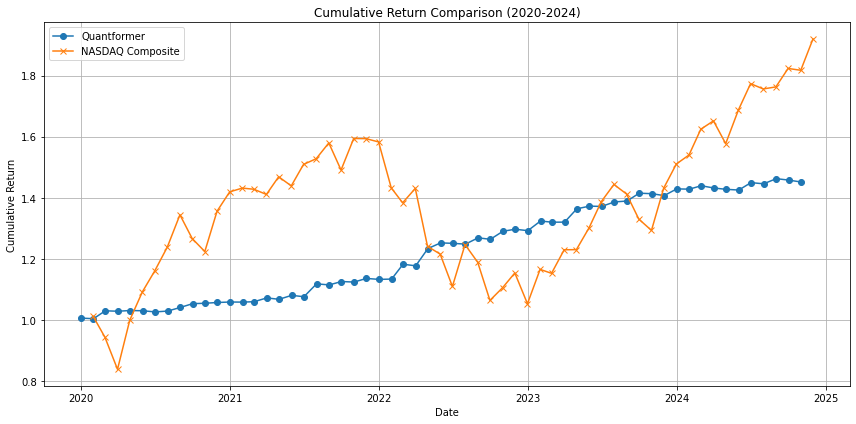

Final Cumulative Return: 0.45140579957281246
Final Cumulative Return - NASDAQ Composite: 91.99%


In [381]:
returns = profit_df.iloc[0]

nasdaq_returns_percent = [
    1.23, -6.78, -11.16, 19.17, 9.31, 6.20, 6.77, 8.54, -5.77, -3.37,
    10.79, 4.67, 0.87, -0.26, -1.19, 4.09, -2.02, 4.88, 1.23, 3.39,
    -5.62, 6.92, -0.02, -0.68, -9.49, -3.43, 3.41, -13.26, -2.05, -8.71,
    12.35, -4.64, -10.50, 3.90, 4.37, -8.73, 10.68, -1.11, 6.69, 0.04,
    5.80, 6.59, 4.05, -2.17, -5.81, -2.78, 10.70, 5.52, 1.95, 5.49,
    1.67, -4.51, 6.96, 5.14, -0.98, 0.38, 3.43, -0.33, 5.65
]
# nasdaq return in the past months

dates = pd.date_range(start="2020-01-01", periods=len(returns), freq='M')
nasdaq_returns = pd.Series(nasdaq_returns_percent, index=dates)


returns.index = pd.to_datetime(returns.index, format="%Y/%m")  
returns = returns.sort_index() 

cumulative_returns = (1 + returns/100).cumprod()
nasdaq_cumulative = (1 + nasdaq_returns / 100).cumprod()


plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, marker='o', label='Quantformer')
plt.plot(nasdaq_cumulative, marker='x', label='NASDAQ Composite')
plt.title('Cumulative Return Comparison (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

final_cumulative_return = cumulative_returns.iloc[-1]
final_nasdaq_return = nasdaq_cumulative.iloc[-1] - 1
print("Final Cumulative Return:", final_cumulative_return-1)
print(f"Final Cumulative Return - NASDAQ Composite: {final_nasdaq_return:.2%}")


In [371]:
#get the max drawdown (MDD)

# cumulative return
cumulative_returns = (1 + returns/100).cumprod()

# swap to the series
cumulative_returns = pd.Series(cumulative_returns.values, index=cumulative_returns.index)

# calculate to the highest point
rolling_max = cumulative_returns.cummax()

# calculate the line of drawdown
drawdown = (cumulative_returns - rolling_max) / rolling_max

# get the MDD
max_drawdown = drawdown.min()

print(f" Max drawdown: {max_drawdown:.2%}")


📉 最大回撤率: -0.98%


In [372]:
# get 95% VaR

profit_series = profit_df.iloc[0]  

# 95% VaR
var_95 = profit_series.quantile(0.05)

print(f" 95% VaR: {var_95:.4f}")


📉 95% VaR: -0.4390
